# Modeling Water Balance of a Landfill

## Introduction
This code represents a conceptual model for the water balance of the Wieringermeer landfill near Medemblik in the Netherlands. 

The model is driven by *rainfall, temperature, and evapotranspiration* data from KNMI weather station in Medemblik.

The landfill produces leachate, measured in m<sup>3</sup>/day. 
Rainfall and evapotranspiration are measured in m/day.
Temperature is in Celsius. 

In [1]:
# Wieringermeer Landfill Characteristics

Base_Area = 28355 # m2
Top_Area = 9100 # m2
Slope_Width = 38 # m
Waste_Body_Height = 12 # m
Cover_Layer_Height = 1.5 # m
Waste_Wet_Weight = 281083000 # kg
# In operation 1992-1998

## Conceptual Model

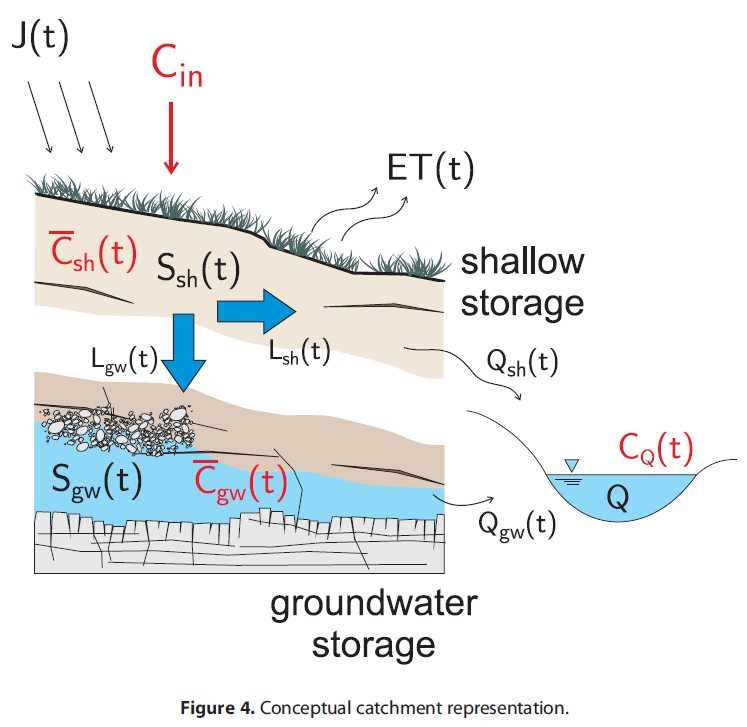

- Input fluxes: J(t), Rainfall
- Output fluxes: Q<sub>dr</sub> (leachate production rate m<sup>3</sup>/day, evapotranspiration, and discharge
- Storage: S(t)



,D
2012-06-14,0.000000
2012-06-15,6.099998
2012-06-16,16.899994
2012-06-17,16.899994
2012-06-18,49.000000


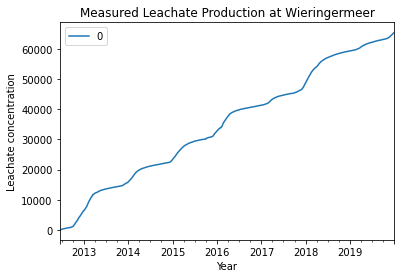

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
%matplotlib inline
df_Meteo = pd.read_excel('WieringermeerData_Meteo.xlsx')

## Make an array out of the precipitation data (in meters/day)
df_Rain = df_Meteo[['datetime','rain_station']]

J = df_Rain.loc[:,'rain_station']
J = J.values

# Make an array out of the evapotranspiration data (in meters/day)
pEV = df_Meteo.loc[:,'pEV']
pEV = pEV.values # m/day

# Make an array out of the temperature data (Celsius)
Temp = df_Meteo.loc[:, 'temp']
Temp = Temp.values

leachate = pd.read_excel('WieringermeerData_LeachateProduction.xlsx', parse_dates=[0], index_col=[0])
leachate.plot(title='Measured Leachate Production at Wieringermeer', xlabel='Year', ylabel='Leachate concentration');

leachate.rename(columns={leachate.columns[0]: "D" }, inplace = True)
leachate.head()

In [3]:
leachate['Daily D'] = ""

leachate['Daily D'] = leachate['D'] - leachate['D'].shift(-1)
leachate['Daily D'] = leachate['Daily D']*-1
leachate['Daily D'] = leachate['Daily D'].shift(1)
leachate['Daily D'] = leachate['Daily D'].fillna(0)
leachate.head()

,D,Daily D
2012-06-14,0.000000,0.000000
2012-06-15,6.099998,6.099998
2012-06-16,16.899994,10.799995
2012-06-17,16.899994,-0.000000
2012-06-18,49.000000,32.100006


Text(0.5, 1.0, 'Weather and discharge data of the Wieringermeer landfill')

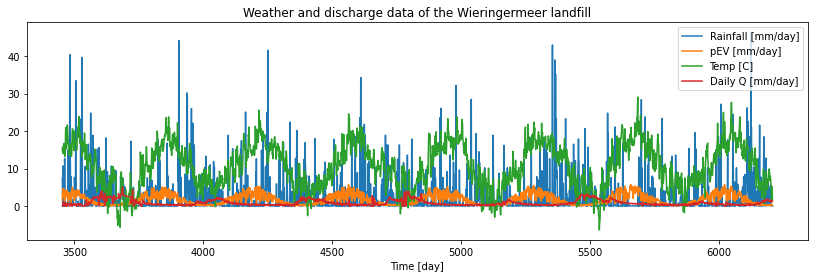

In [4]:
tOut = np.linspace(0, 6209, 6210)  # Whole length of weather data
plt.figure(figsize=(14,4))

# Only used the rows from the Meteo and Leachate databases that have matching dates
day_start = 3453
day_end = 6211
plt.plot(tOut[day_start:day_end], 1000*J[day_start:day_end], label='Rainfall [mm/day]')
plt.plot(tOut[day_start:day_end], 1000*pEV[day_start:day_end], label='pEV [mm/day]')
plt.plot(tOut[day_start:day_end], Temp[day_start:day_end], label='Temp [C]')

plt.plot(tOut[day_start:day_end], 1000*leachate['Daily D']/Base_Area, label='Daily Q [mm/day]') # Q data only has day_start:day_end

plt.xlabel('Time [day]')
plt.legend()
plt.title('Weather and discharge data of the Wieringermeer landfill')

Some observations:

1. Discharge is low when potential evaporation is high, i.e., summer; vice versa.
2. The peaks of daily discharge occur in the end of rain seasons. The landfill probably have a large capacity to store water and a strong ability to damp and delay the precipitation. 

## Conceptual Model: 3 layers
1. Cover layer (cl)
2. Waste body (wb)
3. Drainage layer (dr)

In [5]:
# Parameters (to also analyze in sensitivity analysis)
a_cl = 5 # saturated hydraulic conductivity of the cover layer (m/day)
a_wb = 5 # saturated hydraulic conductivity of the waste body (m/day)
b_cl = 1 # dimensionless empirical parameter for cover layer, taken from paper
b_wb = 1 # dimensionless empirical parameter for waste body, taken from paper
C_f = 0.9 # crop factor; depends on the transpiration and season of the year. assumed value.
n_min = 0.2 # Min porosity
n_max = 0.32 # Max porosity 

# Assuming top layer to be of the top area of 9100 m^2 * 1.5 m = 13650 m^3, and 32 % of that (whihc is the pore space) = 4368 m^3
S_clmin = Top_Area * Cover_Layer_Height * 0.05 # Min storage in the cover layer where water will still freely drain (m3)
                                              # no leak if water content < 0.05 assumed
S_clmax = Top_Area * Cover_Layer_Height * n_max # Max achievable storage in the cover layer (m3)

# f_red, reduction factor reducing evapotranspiration under dry soil conditions
S_EVmin = Top_Area * Cover_Layer_Height * 0.1 # minimum value of pEV data, no evaporation if water content < 0.1 assumed
S_EVmax = Top_Area * Cover_Layer_Height * 0.3 # max value of pEV data 

# Waste Body Parameters
beta_0 = 0.3 # assumed value
vol_ratio = 0.7 # note: the 0.7 was used to account for the smaller volume of the waste body layer
S_wbmin = Base_Area * Waste_Body_Height * vol_ratio * 0.06 # m3
S_wbmax = Base_Area * Waste_Body_Height * vol_ratio * n_max # m3

# Initial storage value
S0 = [Top_Area*Cover_Layer_Height*n_min, Base_Area*Waste_Body_Height*n_min, 0] # [Scl, Swb, Qdr]

### 1. Cover Layer Rate of Change Equation

$$\frac{\mathrm{d}S_{scl}}{\mathrm{d}t} = J(t) - L_{cl}(t) - E(t) $$
  
  Where J(T) = inflow by precipitation \
   Where L<sub>cl</sub>(t) = leachate rate from cover layer
$$L_{cl}(t) = a_{cl} \bigg( \frac{S_{cl} - S_{clmin}}{S_{clmax} - S_{clmin}}\bigg)^ {b_{cl}}$$

Where ET(t) = Evapotranspiration
$$E(t) = pEv(t) * C_{f} * f_{red}$$

Where f<sub>red</sub> is the reduction factor reducing evapotranspiration under dry soil conditions



**Evaporation Model**

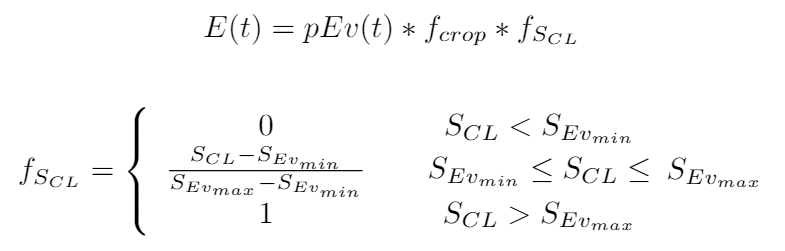

- f<sub>crop</sub> is the crop factor; in this assignment it is the variable C<sub>f</sub>
- f<sub>ScL</sub> is the reduction factor; in this assignment it is the variable f<sub>red</sub>

In [6]:
def f_red(S_cl, S_EVmin, S_EVmax):
    f_red = 0.3 # assumed value
    if S_cl < S_EVmin:
        f_red = 0
    elif S_cl > S_EVmax:
        f_red = 1
    else:
        f_red = (S_cl-S_EVmin)/(S_EVmax-S_EVmin)        
    return f_red

### 2. Waste Body Layer Rate of Change Equation

$$\frac{\mathrm{d}S_{wb}}{\mathrm{d}t} = [(1 - \beta(t))*L_{cl}(t)] - L_{wd}(t) $$

 Where L<sub>cl</sub>(t) = leachate rate from cover layer
$$L_{cl}(t) = a_{cl} \bigg( \frac{S_{cl} - S_{clmin}}{S_{clmax} - S_{clmin}}\bigg)^ {b_{cl}}$$

Where $L_{wb}(t)$ = leachate rate from waste body layer 
$$L_{wb}(t) = a_{wb} \bigg( \frac{S_{wb} - S_{wbmin}}{S_{wbmax} - S_{wbmin}}\bigg)^ {b_{wb}}$$


$\beta$(t) is a term that allows a certain fraction of water leaching from the cover layer directly to the drainage layer 

$$\beta(t) = \beta_{0}* \bigg( \frac{S_{cl} - S_{clmin}}{S_{clmax} - S_{clmin}}\bigg) $$


### 3. Drainage Layer Leachate Production Rate Equation

$$\frac{\mathrm{d}S_{dr}}{\mathrm{d}t} = 0 = \beta(t))*L_{cl}(t) + L_{wd}(t) - Q_{dr}(t) $$


Where $Q_{dr}(t)$ = leachate production rate from the drainage system
$$Q_{dr}(t) = \beta(t)*L_{cl}+L_{wd}(t)$$


## All Rate Equations Together

In [7]:
def dSdt(t, S, S_clmin, S_clmax, S_wbmin, S_wbmax, a_cl, b_cl, a_wb, b_wb):
    """Return the changing rate of the three layers"""
    # S = [Scl, Swb, Qdr]
    
    S_cleff = (S[0]-S_clmin)/(S_clmax-S_clmin)
    S_wbeff = (S[1]-S_wbmin)/(S_wbmax-S_wbmin)
    
    L_cl = a_cl * S_cleff**b_cl
    L_wb = a_wb * S_wbeff**b_wb
    
    beta = (1-beta_0)*S_cleff

    return np.array([Top_Area*((J[int(np.ceil(t))] - L_cl - (pEV[int(np.ceil(t))]*C_f*f_red(S[0],S_EVmin,S_EVmax)))), 
                     (1-beta)*Top_Area*L_cl - Base_Area*L_wb, 
                     beta*Top_Area*L_cl + Base_Area*L_wb])

#### Tic and Toc timer

In [8]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print ("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print ("Toc: start time not set")

## Solving with ODEint

In [9]:
nOut = np.shape(tOut)[0]
print(nOut)
print(tOut)

6210
[0.000e+00 1.000e+00 2.000e+00 ... 6.207e+03 6.208e+03 6.209e+03]


#### Base Case

Elapsed time is 6.3497772216796875 seconds.


Text(0.5, 1.0, 'Discharge')

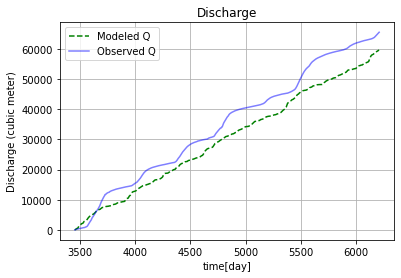

In [22]:
import scipy.integrate as spint

tic()
t_span = [tOut[0], tOut[-1]]
SODE = spint.solve_ivp(dSdt, t_span, S0, t_eval=tOut, vectorized=True,
                      method='RK45', args=(S_clmin, S_clmax, S_wbmin, S_wbmax, a_cl, b_cl, a_wb, b_wb),
                      rtol=1e-5)

# infodict['message'] # >>> 'Integration successful.'
ODE_Scl = SODE.y[0,:]
ODE_Swb = SODE.y[1,:]
ODE_Qdr = SODE.y[2,:]

toc()

plt.figure()
plt.plot(tOut[day_start:day_end], ODE_Qdr[day_start:day_end]-ODE_Qdr[day_start], 'g--', label='Modeled Q') #Observed Q starts at day 3453
plt.plot(tOut[day_start:day_end], leachate['D'], 'b-', alpha=0.5, label='Observed Q')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time[day]')
plt.ylabel('Discharge (cubic meter)')
plt.title('Discharge')


## Sensitivity Analysis

#### Varying a_cl

Elapsed time is 54.596720933914185 seconds.


Text(0.5, 1.0, 'Discharge with changing a_cl')

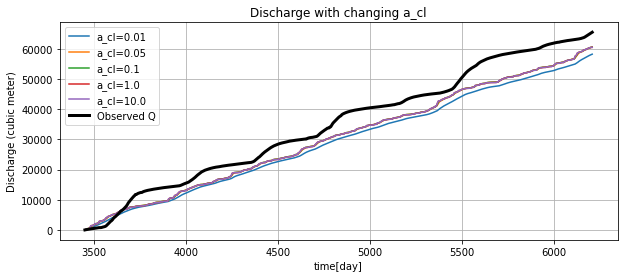

In [11]:
# for sensitivity analysis
a_cl_array = np.array([0.01, 0.05, 0.1, 1, 10])

plt.figure(figsize=(10,4))

tic()

t_span = [tOut[0], tOut[-1]]
for i in range(len(a_cl_array)):
    SODE = spint.solve_ivp(dSdt, t_span, S0, t_eval=tOut, vectorized=True,
                      method='RK45', args=(S_clmin, S_clmax, S_wbmin, S_wbmax, a_cl_array[i], b_cl, a_wb, b_wb), 
                      rtol=1e-5)
    ODE_Scl = SODE.y[0,:]
    ODE_Swb = SODE.y[1,:]
    ODE_Qdr = SODE.y[2,:]
    plt.plot(tOut[day_start:day_end], ODE_Qdr[day_start:day_end]-ODE_Qdr[day_start], 
             label=f'a_cl={a_cl_array[i]}') #Observed Q starts at day 3453

toc()

plt.plot(tOut[day_start:day_end], leachate['D'], 'k-', linewidth=3, label='Observed Q')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time[day]')
plt.ylabel('Discharge (cubic meter)')
plt.title('Discharge with changing a_cl')



#### Varying b_cl

<ipython-input-7-a9ea60dcdf87>:8: RuntimeWarning: overflow encountered in power
  L_cl = a_cl * S_cleff**b_cl
<ipython-input-7-a9ea60dcdf87>:8: RuntimeWarning: overflow encountered in power
  L_cl = a_cl * S_cleff**b_cl
C:\Users\eunic\miniconda3\lib\site-packages\scipy\integrate\_ivp\rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)
<ipython-input-7-a9ea60dcdf87>:8: RuntimeWarning: overflow encountered in power
  L_cl = a_cl * S_cleff**b_cl
C:\Users\eunic\miniconda3\lib\site-packages\scipy\integrate\_ivp\rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)
<ipython-input-7-a9ea60dcdf87>:13: RuntimeWarning: overflow encountered in multiply
  return np.array([Top_Area*((J[int(np.ceil(t))] - L_cl - (pEV[int(np.ceil(t))]*C_f*f_red(S[0],S_EVmin,S_EVmax)))),
<ipython-input-7-a9ea60dcdf87>:14: RuntimeWarning: overflow encountered in multiply
  (1-beta)*Top_Area*

Elapsed time is 31.910277128219604 seconds.


Text(0.5, 1.0, 'Discharge with changing b_cl and closest fit a_cl')

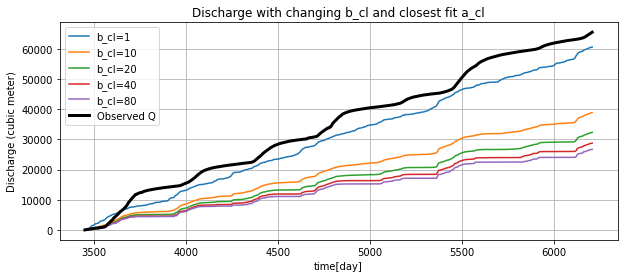

In [12]:
a_cl = 0.1 # using the closest fit value for a_cl

b_cl_array = np.array([1, 10, 20, 40, 80])

plt.figure(figsize=(10,4))

tic()

t_span = [tOut[0], tOut[-1]]
for i in range(len(b_cl_array)):
    SODE = spint.solve_ivp(dSdt, t_span, S0, t_eval=tOut, vectorized=True,
                      method='RK45', args=(S_clmin, S_clmax, S_wbmin, S_wbmax, a_cl, b_cl_array[i], a_wb, b_wb), 
                      rtol=1e-5)
    ODE_Scl = SODE.y[0,:]
    ODE_Swb = SODE.y[1,:]
    ODE_Qdr = SODE.y[2,:]
    plt.plot(tOut[day_start:day_end], ODE_Qdr[day_start:day_end]-ODE_Qdr[day_start], 
             label=f'b_cl={b_cl_array[i]}') #Observed Q starts at day 3453

toc()

plt.plot(tOut[day_start:day_end], leachate['D'], 'k-', linewidth=3, label='Observed Q')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time[day]')
plt.ylabel('Discharge (cubic meter)')
plt.title('Discharge with changing b_cl and closest fit a_cl')

#### Varying a_wb

Elapsed time is 68.67754769325256 seconds.


Text(0.5, 1.0, 'Discharge with changing a_wb and closest fit a_cl & b_cl')

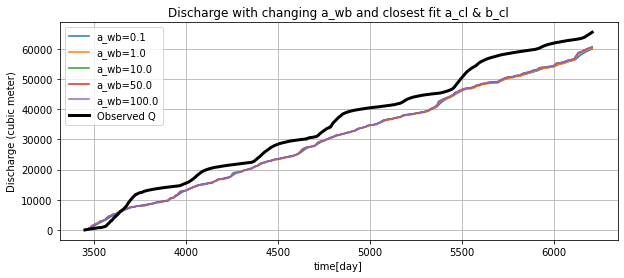

In [13]:
b_cl = 1 # using closest fit b_cl

a_wb_array = np.array([0.1, 1, 10, 50,100])

plt.figure(figsize=(10,4))

tic()

t_span = [tOut[0], tOut[-1]]
for i in range(len(a_wb_array)):
    SODE = spint.solve_ivp(dSdt, t_span, S0, t_eval=tOut, vectorized=True,
                      method='RK45', args=(S_clmin, S_clmax, S_wbmin, S_wbmax, a_cl, b_cl, a_wb_array[i], b_wb), 
                      rtol=1e-5)
    ODE_Scl = SODE.y[0,:]
    ODE_Swb = SODE.y[1,:]
    ODE_Qdr = SODE.y[2,:]
    plt.plot(tOut[day_start:day_end], ODE_Qdr[day_start:day_end]-ODE_Qdr[day_start], 
             label=f'a_wb={a_wb_array[i]}') #Observed Q starts at day 3453

toc()

plt.plot(tOut[day_start:day_end], leachate['D'], 'k-', linewidth=3, label='Observed Q')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time[day]')
plt.ylabel('Discharge (cubic meter)')
plt.title('Discharge with changing a_wb and closest fit a_cl & b_cl')

#### Varying b_wb

<ipython-input-7-a9ea60dcdf87>:9: RuntimeWarning: invalid value encountered in power
  L_wb = a_wb * S_wbeff**b_wb


Elapsed time is 41.566843032836914 seconds.


Text(0.5, 1.0, 'Discharge with changing b_wb and closest fit a_cl, b_cl, & a_wb')

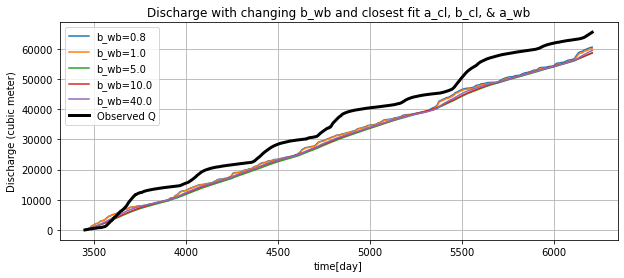

In [14]:
a_wb = 1 # using closest fit a_wb

b_wb_array = np.array([0.8, 1, 5, 10, 40])

plt.figure(figsize=(10,4))

tic()

t_span = [tOut[0], tOut[-1]]
for i in range(len(b_wb_array)):
    SODE = spint.solve_ivp(dSdt, t_span, S0, t_eval=tOut, vectorized=True,
                      method='RK45', args=(S_clmin, S_clmax, S_wbmin, S_wbmax, a_cl, b_cl, a_wb, b_wb_array[i]), 
                      rtol=1e-5)
    ODE_Scl = SODE.y[0,:]
    ODE_Swb = SODE.y[1,:]
    ODE_Qdr = SODE.y[2,:]
    plt.plot(tOut[day_start:day_end], ODE_Qdr[day_start:day_end]-ODE_Qdr[day_start], 
             label=f'b_wb={b_wb_array[i]}') #Observed Q starts at day 3453

toc()

plt.plot(tOut[day_start:day_end], leachate['D'], 'k-', linewidth=3, label='Observed Q')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time[day]')
plt.ylabel('Discharge (cubic meter)')
plt.title('Discharge with changing b_wb and closest fit a_cl, b_cl, & a_wb')

In [15]:
b_wb = 1 # using closest fit b_wb

### Varying Storage Parameters using closest fit for saturated hydraulic conductivity and empirical values

#### Varying S_clmin

Elapsed time is 39.353755235672 seconds.


Text(0.5, 1.0, 'Discharge with changing S_clmin')

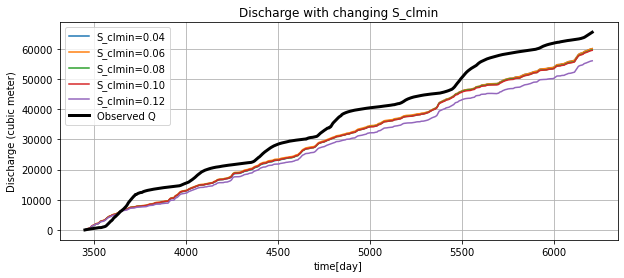

In [16]:
S_clmin = Top_Area*Cover_Layer_Height*np.array([0.04, 0.06, 0.08, 0.1, 0.12]) # Array represents varying values of water content

plt.figure(figsize=(10,4))

tic()

t_span = [tOut[0], tOut[-1]]
for i in range(len(S_clmin)):
    SODE = spint.solve_ivp(dSdt, t_span, S0, t_eval=tOut, vectorized=True,
                      method='RK45', args=(S_clmin[i], S_clmax, S_wbmin, S_wbmax, a_cl, b_cl, a_wb, b_wb), 
                      rtol=1e-5)
    ODE_Scl = SODE.y[0,:]
    ODE_Swb = SODE.y[1,:]
    ODE_Qdr = SODE.y[2,:]
    plt.plot(tOut[day_start:day_end], ODE_Qdr[day_start:day_end]-ODE_Qdr[day_start], 
             label=f'S_clmin={S_clmin[i]/Top_Area/Cover_Layer_Height:.2f}') # Observed Q starts at day 3453

toc()

plt.plot(tOut[day_start:day_end], leachate['D'], 'k-', linewidth=3, label='Observed Q')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time[day]')
plt.ylabel('Discharge (cubic meter)')
plt.title('Discharge with changing S_clmin')

#### Varying S_clmax

Elapsed time is 32.35454082489014 seconds.


Text(0.5, 1.0, 'Discharge with changing S_clmax and closest fit S_clmin')

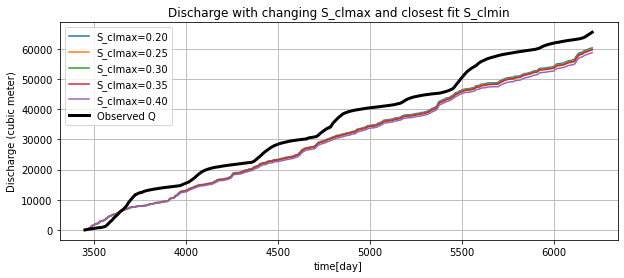

In [17]:
S_clmin = Top_Area*Cover_Layer_Height*0.1 # used closest fit for porosity

S_clmax = Top_Area*Cover_Layer_Height*np.array([0.2, 0.25, 0.3, 0.35, 0.4])

plt.figure(figsize=(10,4))

tic()

t_span = [tOut[0], tOut[-1]]
for i in range(len(S_clmax)):
    SODE = spint.solve_ivp(dSdt, t_span, S0, t_eval=tOut, vectorized=True,
                      method='RK45', args=(S_clmin, S_clmax[i], S_wbmin, S_wbmax, a_cl, b_cl, a_wb, b_wb), 
                      rtol=1e-5)
    ODE_Scl = SODE.y[0,:]
    ODE_Swb = SODE.y[1,:]
    ODE_Qdr = SODE.y[2,:]
    plt.plot(tOut[day_start:day_end], ODE_Qdr[day_start:day_end]-ODE_Qdr[day_start], 
             label=f'S_clmax={S_clmax[i]/Top_Area/Cover_Layer_Height:.2f}') #Observed Q starts at day 3453

toc()

plt.plot(tOut[day_start:day_end], leachate['D'], 'k-', linewidth=3, label='Observed Q')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time[day]')
plt.ylabel('Discharge (cubic meter)')
plt.title('Discharge with changing S_clmax and closest fit S_clmin')

#### Varying S_wbmin

Elapsed time is 33.567097187042236 seconds.


Text(0.5, 1.0, 'Discharge with changing S_wbmin and closest fit S_clmin & S_clmax')

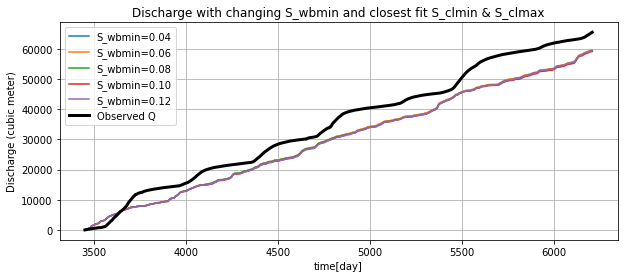

In [18]:
S_clmax = Top_Area*Cover_Layer_Height*0.35 # using closest fit for S_clmax

S_wbmin = Base_Area*Waste_Body_Height*vol_ratio*np.array([0.04, 0.06, 0.08, 0.1, 0.12])

plt.figure(figsize=(10,4))

tic()

t_span = [tOut[0], tOut[-1]]
for i in range(len(S_wbmin)):
    SODE = spint.solve_ivp(dSdt, t_span, S0, t_eval=tOut, vectorized=True,
                      method='RK45', args=(S_clmin, S_clmax, S_wbmin[i], S_wbmax, a_cl, b_cl, a_wb, b_wb), 
                      rtol=1e-5)
    ODE_Scl = SODE.y[0,:]
    ODE_Swb = SODE.y[1,:]
    ODE_Qdr = SODE.y[2,:]
    plt.plot(tOut[day_start:day_end], ODE_Qdr[day_start:day_end]-ODE_Qdr[day_start], 
             label=f'S_wbmin={S_wbmin[i]/Base_Area/Waste_Body_Height/vol_ratio:.2f}') #Observed Q starts at day 3453

toc()

plt.plot(tOut[day_start:day_end], leachate['D'], 'k-', linewidth=3, label='Observed Q')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time[day]')
plt.ylabel('Discharge (cubic meter)')
plt.title('Discharge with changing S_wbmin and closest fit S_clmin & S_clmax')

#### Varying S_wbmax

Elapsed time is 34.50184941291809 seconds.


Text(0.5, 1.0, 'Discharge with changing S_wbmin and closest fit S_clmin, S_clmax, & S_wbmin')

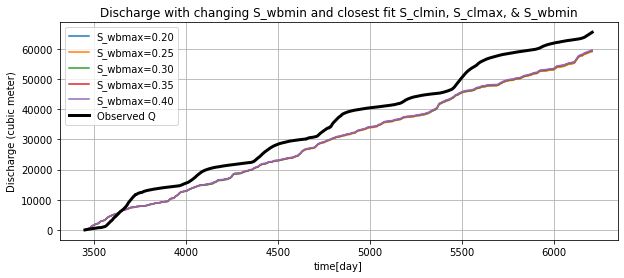

In [19]:
S_wbmin = Base_Area*Waste_Body_Height*vol_ratio*0.06 # using closest fit

S_wbmax = Base_Area*Waste_Body_Height*vol_ratio*np.array([0.2, 0.25, 0.3, 0.35, 0.4])


plt.figure(figsize=(10,4))

tic()

t_span = [tOut[0], tOut[-1]]
for i in range(len(S_wbmax)):
    SODE = spint.solve_ivp(dSdt, t_span, S0, t_eval=tOut, vectorized=True,
                      method='RK45', args=(S_clmin, S_clmax, S_wbmin, S_wbmax[i], a_cl, b_cl, a_wb, b_wb), 
                      rtol=1e-5)
    ODE_Scl = SODE.y[0,:]
    ODE_Swb = SODE.y[1,:]
    ODE_Qdr = SODE.y[2,:]
    plt.plot(tOut[day_start:day_end], ODE_Qdr[day_start:day_end]-ODE_Qdr[day_start], 
             label=f'S_wbmax={S_wbmax[i]/Base_Area/Waste_Body_Height/vol_ratio:.2f}') #Observed Q starts at day 3453

toc()

plt.plot(tOut[day_start:day_end], leachate['D'], 'k-', linewidth=3, label='Observed Q')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time[day]')
plt.ylabel('Discharge (cubic meter)')
plt.title('Discharge with changing S_wbmin and closest fit S_clmin, S_clmax, & S_wbmin')

In [20]:
S_wbmax = Base_Area*Waste_Body_Height*vol_ratio*0.4 # used closest fit 

### Compare observed and modeled daily discharge

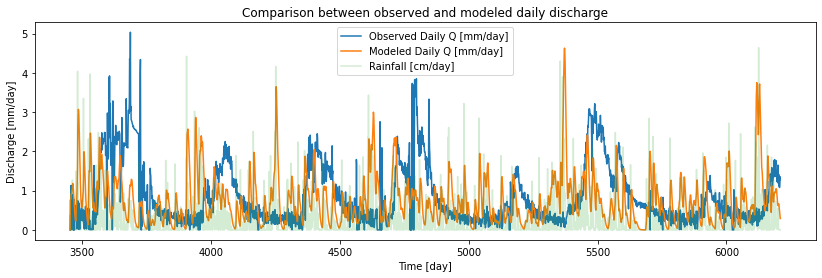

In [21]:
cum_Q = ODE_Qdr[day_start:day_end]-ODE_Qdr[day_start] # cum_Q: Modeled cumulative discharge [m3/day]
daily_Q = np.ones(len(cum_Q)) # Convert to daily discharge [m3/day]
for i in range(len(cum_Q)):
    if i == 0:
        daily_Q[i] = cum_Q[i]
    else:
        daily_Q[i] = cum_Q[i] - cum_Q[i-1]
        
plt.figure(figsize=(14, 4))
plt.plot(tOut[day_start:day_end], 1000*leachate['Daily D']/Base_Area, label='Observed Daily Q [mm/day]')
plt.plot(tOut[day_start:day_end], 1000*daily_Q/Base_Area, label='Modeled Daily Q [mm/day]')
plt.title('Comparison between observed and modeled daily discharge')
plt.xlabel('Time [day]')
plt.ylabel('Discharge [mm/day]')
plt.plot(tOut[day_start:day_end], 100*J[day_start:day_end], alpha=0.2, label='Rainfall [cm/day]')
#plt.plot(tOut[day_start:day_end], 1000*pEV[day_start:day_end], alpha=0.5,label='pEV [mm/day]')
#plt.plot(tOut[day_start:day_end], Temp[day_start:day_end], alpha=0.5,label='Temp[c]')
plt.legend()